In [1]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import pywt

In [2]:
samples = pd.read_csv('../sample_sheet.csv')
samples = samples[samples['Region'] == 'M1_L5']
samples

,SID,AnimalID,CellName,Region,Date,Depth,Count,Location
32,W2_C7,W2,C7,M1_L5,2019 12 12,502.251954,510,W2/C7
33,W3_C4,W3,C4,M1_L5,2019 12 17,581.036574,590,W3/C4
34,W3_C5,W3,C5,M1_L5,2019 12 17,492.403877,500,W3/C5
35,W3_C6,W3,C6,M1_L5,2019 12 17,763.226009,775,W3/C6
36,W3_C8,W3,C8,M1_L5,2019 12 17,640.125039,650,W3/C8
37,W4_C3,W4,C3,M1_L5,2019 12 17,915.871210,930,W4/C3
38,W4_C4,W4,C4,M1_L5,2019 12 17,649.973117,660,W4/C4
39,W4_C5,W4,C5,M1_L5,2019 12 17,600.732729,610,W4/C5
40,W4_C7,W4,C7,M1_L5,2019 12 17,581.036574,590,W4/C7
41,W4_C8,W4,C8,M1_L5,2019 12 17,876.478900,890,W4/C8


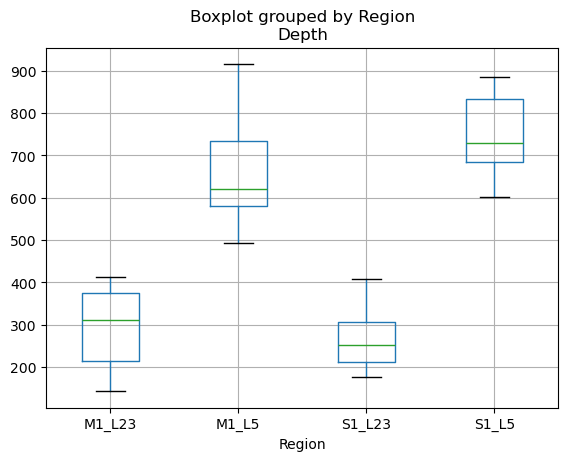

In [3]:
pd.read_csv('../sample_sheet.csv').boxplot(column = 'Depth', by = 'Region')  # Do the firing patterns depend on cortical depth?
plt.show()

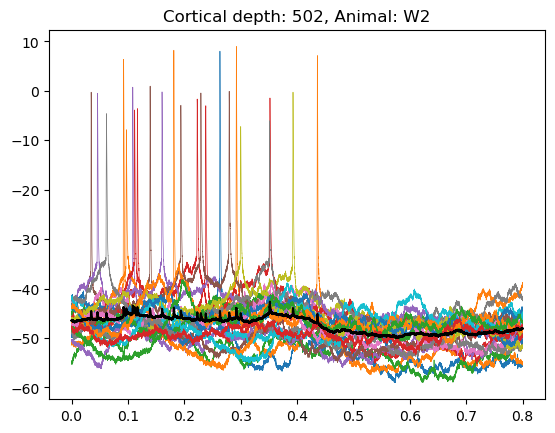

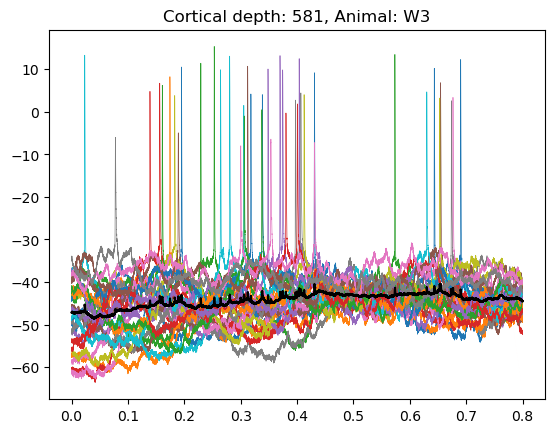

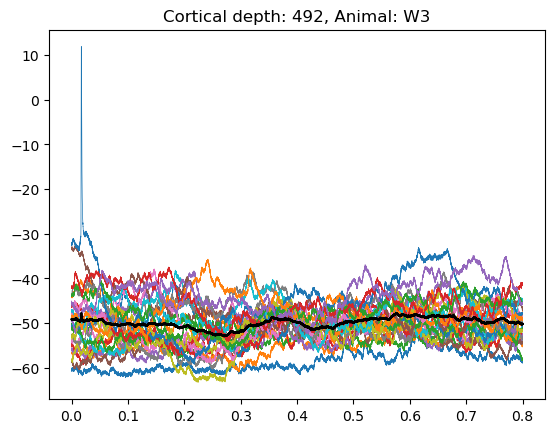

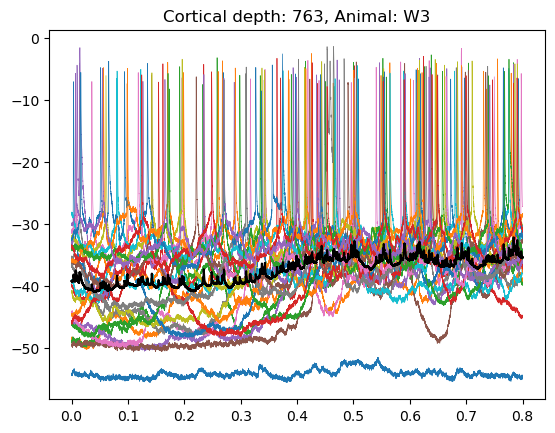

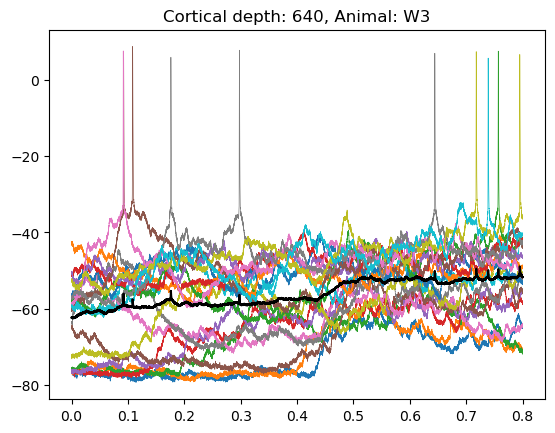

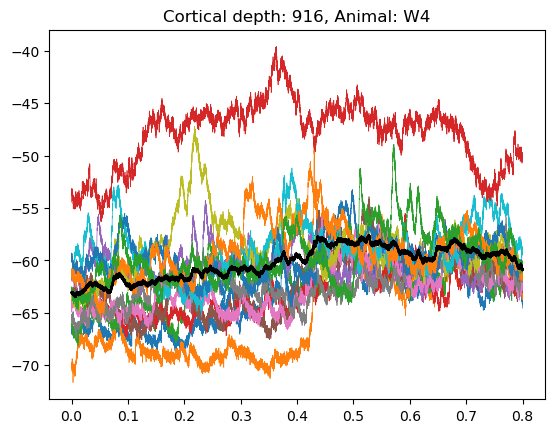

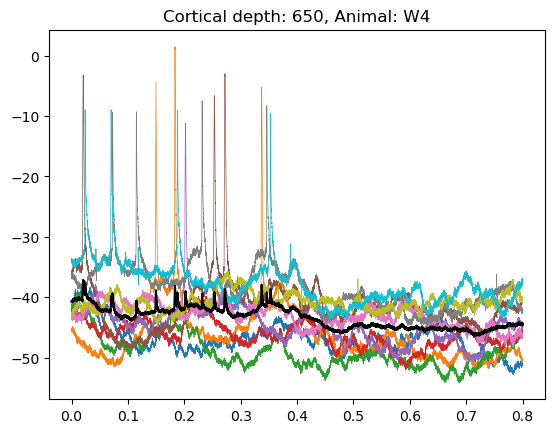

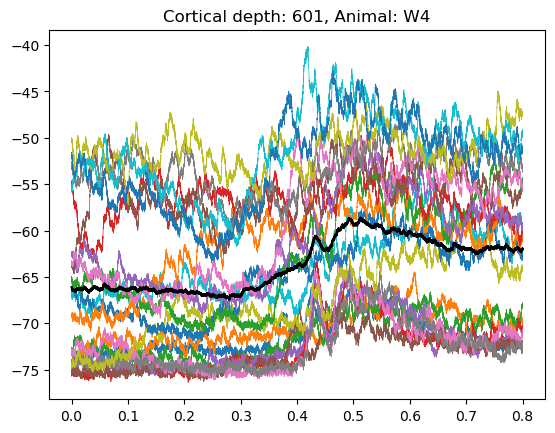

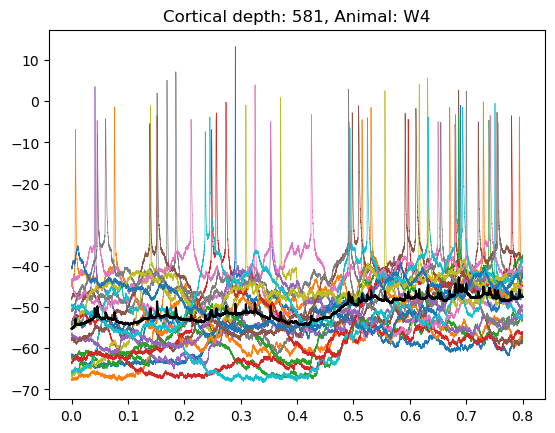

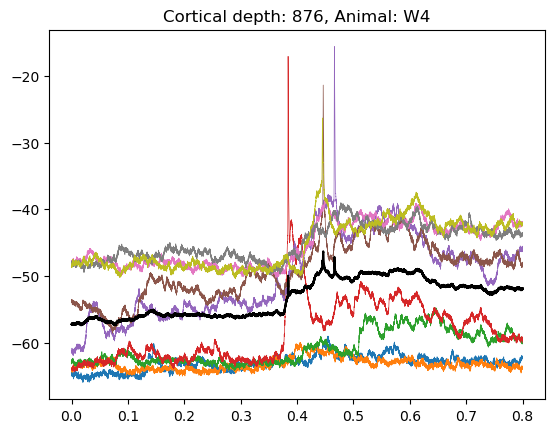

In [4]:
for index, sample in samples.iterrows():
    movement_events = pd.read_csv(
        f'../output/spontaneous-movement/{sample["AnimalID"]}/{sample["CellName"]}/movement_final.csv')
    data = pd.read_pickle(f'../output/spontaneous-movement/{sample["AnimalID"]}/{sample["CellName"]}/vm/raw.pkl')

    event_y = []
    event_x = []

    for index, event in movement_events.iterrows():
        event_data = data.copy().pick(picks = event['ChannelID']).crop(tmin = event['Start'] - 0.4,
                                                                       tmax = event['Start'] + 0.4)

        x = event_data.times
        y = event_data.get_data()[0, :]

        event_y.append(y)
        event_x = x

        plt.plot(x, y, linewidth = 0.5)

    event_mean = np.mean(event_y, axis = 0)
    plt.plot(event_x, event_mean, c = 'black')
    plt.title(f'Cortical depth: {round(sample["Depth"])}, Animal: {sample["AnimalID"]}')
    plt.show()

# Short Time Fourier Tranform (STFT)

In [5]:
from scipy.signal import stft

samples = pd.read_csv('../sample_sheet.csv')
sample = samples.iloc[0]
movement_events = pd.read_csv(
    f'../output/spontaneous-movement/{sample["AnimalID"]}/{sample["CellName"]}/movement_final.csv')
data = pd.read_pickle(f'../output/spontaneous-movement/{sample["AnimalID"]}/{sample["CellName"]}/vm/raw.pkl')

In [6]:
event = movement_events.iloc[0]
event_data = data.copy().pick(picks = event['ChannelID']).crop(tmin = event['Start'] - 0.4,
                                                               tmax = event['Start'] + 0.4)

x = event_data.times
y = event_data.get_data()[0, :]

In [7]:
freq, time, zxx = stft(y, fs = 20_000, nperseg = 1024, scaling = 'psd')
# Larger nperseg = larger time step, smaller frequency step
# Smaller nperseg = smaller time step, larger frequency step

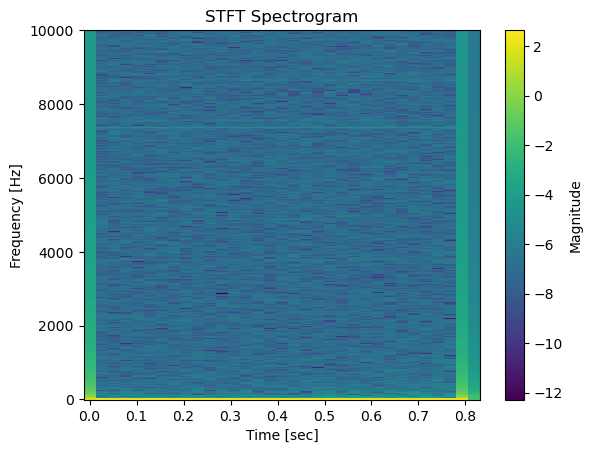

In [8]:
plt.pcolormesh(time, freq, np.log(np.abs(zxx)), shading = 'auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('STFT Spectrogram')
plt.colorbar(label = 'Magnitude')
plt.show()

In [9]:
sample = samples.iloc[0]
movement_events = pd.read_csv(
    f'../output/spontaneous-movement/{sample["AnimalID"]}/{sample["CellName"]}/movement_final.csv')
data = pd.read_pickle(f'../output/spontaneous-movement/{sample["AnimalID"]}/{sample["CellName"]}/vm/raw.pkl')

In [10]:
transform = []

for index, event in movement_events.iterrows():
    event_data = data.copy().pick(picks = event['ChannelID']).crop(tmin = event['Start'] - 0.4,
                                                                   tmax = event['Start'] + 0.4)

    x = event_data.times
    y = event_data.get_data()[0, :]
    freq, time, zxx = stft(y, fs = 20_000, nperseg = 1024, scaling = 'psd')

    transform.append(np.abs(zxx))

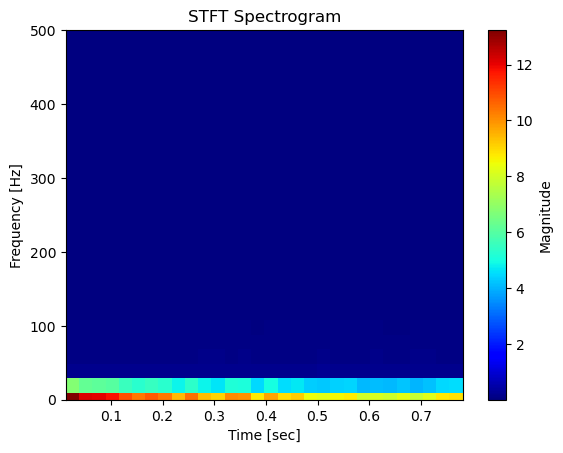

In [11]:
plt.pcolormesh(time[1:-2], freq, np.mean(transform, axis = 2).T, shading = 'auto', cmap = 'jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('STFT Spectrogram')
plt.colorbar(label = 'Magnitude')
plt.ylim(0, 500)
plt.show()

# Fast Fourier Transform During Movement vs During Rest

In [12]:
from scipy.fft import fft, fftfreq

In [13]:
samples = pd.read_csv('../sample_sheet.csv')
sample = samples.iloc[0]

movement_events = pd.read_csv(f'../output/spontaneous-movement/{sample["AnimalID"]}/{sample["CellName"]}/movement_final.csv')
no_movement_events = pd.read_csv(f'../output/spontaneous-movement/{sample["AnimalID"]}/{sample["CellName"]}/no_movement_final.csv')
data = pd.read_pickle(f'../output/spontaneous-movement/{sample["AnimalID"]}/{sample["CellName"]}/vm/raw.pkl')

sample_rate = 20_000  # Hz

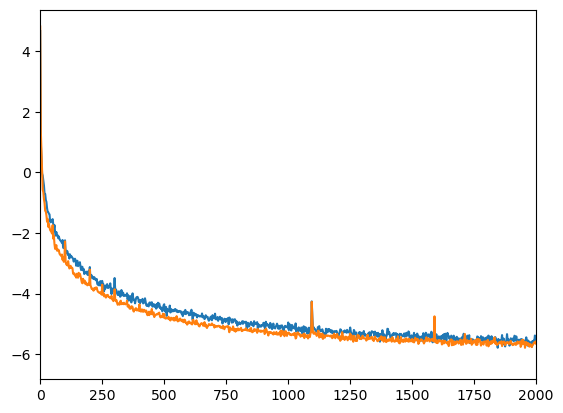

In [14]:
event_fft = []
no_event_fft = []
event_fft_freq = []

for index, event in movement_events.iterrows():
    event_data = data.copy().pick(picks = event['ChannelID']).crop(tmin = event['Start'], tmax = event['Start'] + 0.4)

    x = event_data.times
    y = event_data.get_data()[0, :]

    fft_res = 2.0 / len(y) * np.abs(fft(y)[0:len(y) // 2])

    event_fft_freq = fftfreq(len(y), 1 / sample_rate)[:len(y) // 2]
    event_fft.append(fft_res)

for index, event in no_movement_events.iterrows():
    event_data = data.copy().pick(picks = event['ChannelID']).crop(tmin = event['Start'], tmax = event['Start'] + 0.4)

    x = event_data.times
    y = event_data.get_data()[0, :]

    fft_res = 2.0 / len(y) * np.abs(fft(y)[0:len(y) // 2])
    no_event_fft.append(fft_res)

mean_fft = np.mean(event_fft, axis = 0)
mean_rest_fft = np.mean(no_event_fft, axis = 0)

plt.plot(event_fft_freq, np.log(mean_fft))
plt.plot(event_fft_freq, np.log(mean_rest_fft))
plt.xlim(0, 2000)
plt.show()

In [15]:
s1_l23 = []
s1_l5 = []
m1_l23 = []
m1_l5 = []
s1_l23_rest = []
s1_l5_rest = []
m1_l23_rest = []
m1_l5_rest = []
event_fft_freq = []

for i, sample in samples.iterrows():
    movement_events = pd.read_csv(f'../output/spontaneous-movement/{sample["AnimalID"]}/{sample["CellName"]}/movement_final.csv')
    data = pd.read_pickle(f'../output/spontaneous-movement/{sample["AnimalID"]}/{sample["CellName"]}/vm/raw.pkl')

    event_fft = []
    
    for index, event in movement_events.iterrows():
        event_data = data.copy().pick(picks = event['ChannelID']).crop(tmin = event['Start'], tmax = event['Start'] + 0.4)
    
        x = event_data.times
        y = event_data.get_data()[0, :]
    
        fft_res = 2.0 / len(y) * np.abs(fft(y)[0:len(y) // 2])
    
        event_fft_freq = fftfreq(len(y), 1 / sample_rate)[:len(y) // 2]
        event_fft.append(fft_res)
    
    mean_fft = np.mean(event_fft, axis = 0)
    
    if sample['Region'] == 'S1_L23':
        s1_l23.append(mean_fft)
    if sample['Region'] == 'S1_L5':
        s1_l5.append(mean_fft)
    if sample['Region'] == 'M1_L23':
        m1_l23.append(mean_fft)
    if sample['Region'] == 'M1_L5':
        m1_l5.append(mean_fft)

    movement_events = pd.read_csv(f'../output/spontaneous-movement/{sample["AnimalID"]}/{sample["CellName"]}/no_movement_final.csv')

    for index, event in movement_events.iterrows():
        event_data = data.copy().pick(picks = event['ChannelID']).crop(tmin = event['Start'], tmax = event['Start'] + 0.4)

        x = event_data.times
        y = event_data.get_data()[0, :]

        fft_res = 2.0 / len(y) * np.abs(fft(y)[0:len(y) // 2])
        event_fft.append(fft_res)

    mean_fft = np.mean(event_fft, axis = 0)

    if sample['Region'] == 'S1_L23':
        s1_l23_rest.append(mean_fft)
    if sample['Region'] == 'S1_L5':
        s1_l5_rest.append(mean_fft)
    if sample['Region'] == 'M1_L23':
        m1_l23_rest.append(mean_fft)
    if sample['Region'] == 'M1_L5':
        m1_l5_rest.append(mean_fft)

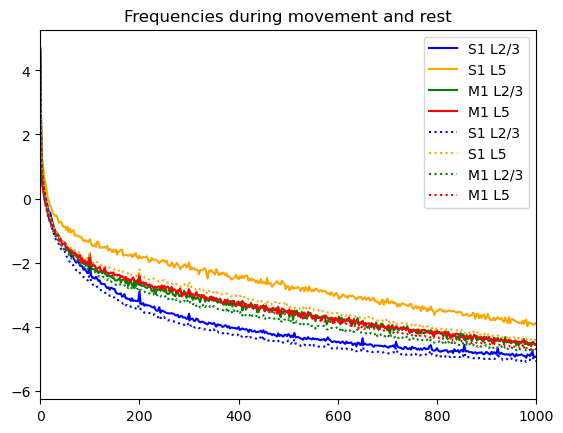

In [16]:
plt.plot(event_fft_freq, np.log(np.mean(s1_l23, axis = 0)), label = 'S1 L2/3', c = 'blue')
plt.plot(event_fft_freq, np.log(np.mean(s1_l5, axis = 0)), label = 'S1 L5', c = 'orange')
plt.plot(event_fft_freq, np.log(np.mean(m1_l23, axis = 0)), label = 'M1 L2/3', c = 'green')
plt.plot(event_fft_freq, np.log(np.mean(m1_l5, axis = 0)), label = 'M1 L5', c = 'red')
plt.plot(event_fft_freq, np.log(np.mean(s1_l23_rest, axis = 0)), label = 'S1 L2/3', linestyle = 'dotted', c = 'blue')
plt.plot(event_fft_freq, np.log(np.mean(s1_l5_rest, axis = 0)), label = 'S1 L5', linestyle = 'dotted', c = 'orange')
plt.plot(event_fft_freq, np.log(np.mean(m1_l23_rest, axis = 0)), label = 'M1 L2/3', linestyle = 'dotted', c = 'green')
plt.plot(event_fft_freq, np.log(np.mean(m1_l5_rest, axis = 0)), label = 'M1 L5', linestyle = 'dotted', c = 'red')
plt.legend()
plt.xlim(0, 1000)
plt.title('Frequencies during movement and rest')
plt.show()

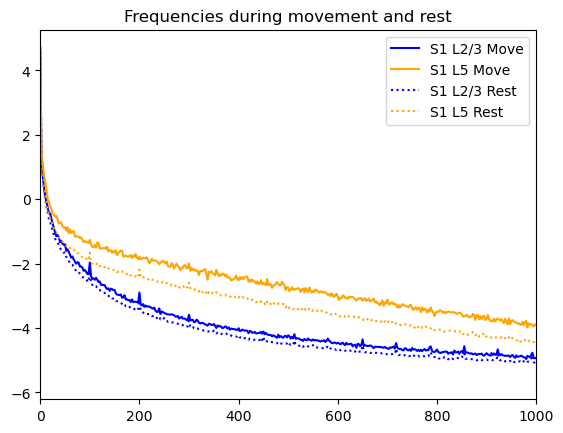

In [17]:
plt.plot(event_fft_freq, np.log(np.mean(s1_l23, axis = 0)), label = 'S1 L2/3 Move', c = 'blue')
plt.plot(event_fft_freq, np.log(np.mean(s1_l5, axis = 0)), label = 'S1 L5 Move', c = 'orange')
plt.plot(event_fft_freq, np.log(np.mean(s1_l23_rest, axis = 0)), label = 'S1 L2/3 Rest', linestyle = 'dotted', c = 'blue')
plt.plot(event_fft_freq, np.log(np.mean(s1_l5_rest, axis = 0)), label = 'S1 L5 Rest', linestyle = 'dotted', c = 'orange')
plt.legend()
plt.xlim(0, 1000)
plt.title('Frequencies during movement and rest')
plt.show()

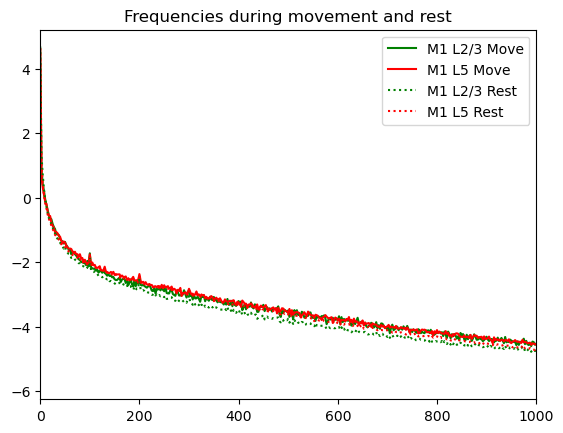

In [18]:
plt.plot(event_fft_freq, np.log(np.mean(m1_l23, axis = 0)), label = 'M1 L2/3 Move', c = 'green')
plt.plot(event_fft_freq, np.log(np.mean(m1_l5, axis = 0)), label = 'M1 L5 Move', c = 'red')
plt.plot(event_fft_freq, np.log(np.mean(m1_l23_rest, axis = 0)), label = 'M1 L2/3 Rest', linestyle = 'dotted', c = 'green')
plt.plot(event_fft_freq, np.log(np.mean(m1_l5_rest, axis = 0)), label = 'M1 L5 Rest', linestyle = 'dotted', c = 'red')
plt.legend()
plt.xlim(0, 1000)
plt.title('Frequencies during movement and rest')
plt.show()

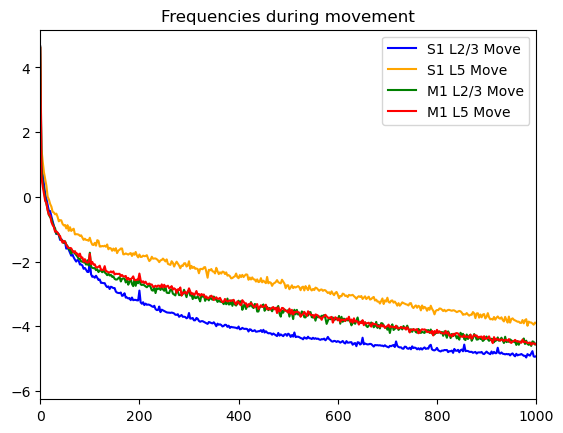

In [19]:
plt.plot(event_fft_freq, np.log(np.mean(s1_l23, axis = 0)), label = 'S1 L2/3 Move', c = 'blue')
plt.plot(event_fft_freq, np.log(np.mean(s1_l5, axis = 0)), label = 'S1 L5 Move', c = 'orange')
plt.plot(event_fft_freq, np.log(np.mean(m1_l23, axis = 0)), label = 'M1 L2/3 Move', c = 'green')
plt.plot(event_fft_freq, np.log(np.mean(m1_l5, axis = 0)), label = 'M1 L5 Move', c = 'red')
plt.legend()
plt.xlim(0, 1000)
plt.title('Frequencies during movement')
plt.show()

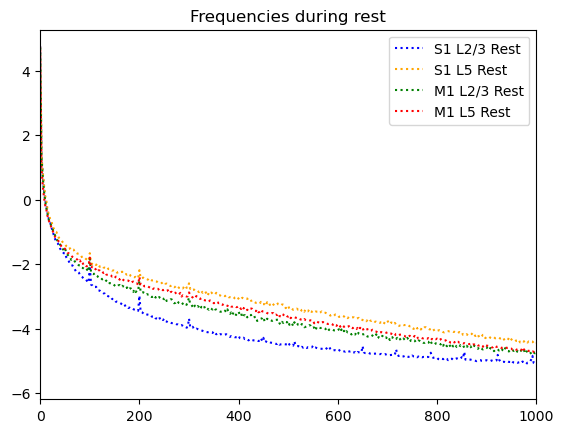

In [25]:
plt.plot(event_fft_freq, np.log(np.mean(s1_l23_rest, axis = 0)), label = 'S1 L2/3 Rest', linestyle = 'dotted', c = 'blue')
plt.plot(event_fft_freq, np.log(np.mean(s1_l5_rest, axis = 0)), label = 'S1 L5 Rest', linestyle = 'dotted', c = 'orange')
plt.plot(event_fft_freq, np.log(np.mean(m1_l23_rest, axis = 0)), label = 'M1 L2/3 Rest', linestyle = 'dotted', c = 'green')
plt.plot(event_fft_freq, np.log(np.mean(m1_l5_rest, axis = 0)), label = 'M1 L5 Rest', linestyle = 'dotted', c = 'red')
plt.legend()
plt.xlim(0, 1000)
plt.title('Frequencies during rest')
plt.show()

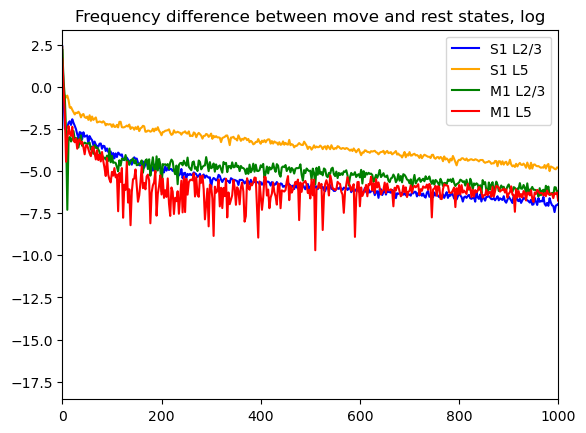

In [26]:
plt.plot(event_fft_freq, np.log(np.abs(np.mean(s1_l23, axis = 0) - np.mean(s1_l23_rest, axis = 0))), label = 'S1 L2/3', c = 'blue')
plt.plot(event_fft_freq, np.log(np.abs(np.mean(s1_l5, axis = 0) - np.mean(s1_l5_rest, axis = 0))), label = 'S1 L5', c = 'orange')
plt.plot(event_fft_freq, np.log(np.abs(np.mean(m1_l23, axis = 0) - np.mean(m1_l23_rest, axis = 0))), label = 'M1 L2/3', c = 'green')
plt.plot(event_fft_freq, np.log(np.abs(np.mean(m1_l5, axis = 0) - np.mean(m1_l5_rest, axis = 0))), label = 'M1 L5', c = 'red')
plt.legend()
plt.xlim(0, 1000)
plt.title('Frequency difference between move and rest states, log')
plt.show()

NOTE: larger value indicates larger difference. The data is log transformed, so negative values indicate smaller change rather than a change in the negative direction.

S1 L5 is most affected by movement.